In [1]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
data_dir = Path("/Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/data/mendel_output")
manifest_dir = Path("/Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/manifest/mendel_output")

In [3]:
our_results_dir = Path("/Users/cpan/Desktop/Entities_compare")

In [4]:
pwd

'/Users/cpan/Desktop'

In [5]:
def load_data_output(data_dir, folder_name):
    data_lst = []
    folder = data_dir / folder_name
    if folder.exists() and folder.is_dir(): 
        json_files = list(folder.glob('*.json')) 
        
        for json_file in json_files: 
            with open(json_file, 'r') as file: 
                for line in file:
                    json_data = json.loads(line)  # Load each line as a separate JSON object
                    data_lst.append(json_data)
    else:
        print("The folder does not exist")
    return data_lst

def load_json_our_results(file_name):
    file_path = our_results_dir / file_name
    with open(file_path, 'r') as file:
        json_data = json.load(file)
        
    json_data_df = pd.DataFrame(json_data)
    return json_data_df

In [7]:
melanoma_data = load_data_output(data_dir, 'melanoma')

In [8]:
melanoma_data_manifest = load_data_output(manifest_dir, 'melanoma')

In [9]:
print(len(melanoma_data))
print(len(melanoma_data_manifest))

2257
140


In [10]:
melanoma_data[0]

{'patient_id': 'pt-01h5b98yec4rwck1vcehnmzrka',
 'event_id': 'evt-01h6pdy76k6pgddhb328kp6cek',
 'event_type': 'Neoplasm',
 'endpoint_name': 'Neoplasm',
 'property_type': 'Concept',
 'property_value_type': 'Concept',
 'concept_values': [{'concept_name': 'Melanoma', 'mendel_cid': '20642'}],
 'property_evidences': [{'document_id': 'doc-01h5nw9s3djvr5k3ctjx7wjx7r',
   'mention': 'malignant melanoma',
   'start_char': 1146,
   'end_char': 1164}]}

In [11]:
melanoma_data_manifest[0]

{'mendel_patient_id': 'pt-01h5b98yec4rwck1vcehnmzrka',
 'customer_patient_id': 'A0552327',
 'resolve_path': 's3://mendel-guardant-data/outbound/073123/data/mendel_output/melanoma/pt-01h5b98yec4rwck1vcehnmzrka.json',
 'tenant_num': 1,
 'tenant_domain': 'https://gdt1-api-sandbox.mendel.ai/v1/',
 'site_name': 'guardant'}

In [12]:
def create_matched_dataframe(data, manifest):
    # Create DataFrames from the lists
    data_df = pd.DataFrame(data)
    manifest_df = pd.DataFrame(manifest)
    
    # Merge the DataFrames based on 'patient_id' and 'mendel_patient_id'
    merged_df = pd.merge(data_df, manifest_df,
                         left_on='patient_id', right_on='mendel_patient_id')
    
    # Extract 'mention' from 'property_evidences' list of dictionaries
    merged_df['mention'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['mention'] if isinstance(x, list) and len(x) > 0 else None)
    
    # Extract all concept names from 'concept_values' lists
    merged_df['all_concept_names'] = merged_df['concept_values'].apply(
        lambda x: ', '.join([c['concept_name'] for c in x]) if isinstance(x, list) else None)
    
    # Extract 'document_id', 'start_char', and 'end_char' for the corresponding 'mention'
    merged_df['document_id'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['document_id'] if isinstance(x, list) and len(x) > 0 else None)
    merged_df['start_char'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['start_char'] if isinstance(x, list) and len(x) > 0 else None)
    merged_df['end_char'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['end_char'] if isinstance(x, list) and len(x) > 0 else None)
    
    # Select the desired columns
    selected_columns = ['customer_patient_id', 'event_type', 'confidence_score', 
                        'property_type', 'property_value_type', 'mention', 'all_concept_names',
                        'document_id', 'start_char', 'end_char']
    
    # Create the final DataFrame with selected columns
    final_df = merged_df[selected_columns].copy()
    
    return final_df

In [13]:
melanoma_mendel_df = create_matched_dataframe(melanoma_data, melanoma_data_manifest)

In [14]:
melanoma_mendel_df.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char
0,A0552327,Neoplasm,NaN,Concept,Concept,malignant melanoma,Melanoma,doc-01h5nw9s3djvr5k3ctjx7wjx7r,1146.0,1164.0
1,A0552327,Smoking Status,NaN,Concept,Concept,Non smoker,Never Smoker,doc-01h5nw9s3djvr5k3ctjx7wjx7r,3352.0,3362.0
2,A0552327,ECOG Status,NaN,Concept,Concept,ECOG 0,ECOG 0,doc-01h5nw9s3djvr5k3ctjx7wjx7r,3426.0,3432.0
3,A0550121,ECOG Status,0.414302,Concept,Concept,ECOG Performance: 0,ECOG 0,doc-01h5jm4xvrf1hdm534s60d2dbb,2711.0,2730.0
4,A0550121,Neoplasm,NaN,Concept,Concept,melanoma,Melanoma,doc-01h5jm4xvrf1hdm534s60d2dbb,412.0,420.0


In [15]:
# load our results 
melanoma_our_df = load_json_our_results('melanoma_cancer_148_docs_entities.json')

In [16]:
melanoma_our_df.head()

,file_name,dates,important dates,diseases,smoking,smoking_keyword,ecogs,test_results
0,A0543566_MedRec1.txt,"[{'start': 1, 'end': 11, 'text': '12/20/2022',...",[{'keyword': 'received: volume: _ appearance: ...,"[{'start': 157, 'end': 173, 'text': 'liver met...",yes,smoker,[],[]
1,A0582186_MedRec1.txt,"[{'start': 182, 'end': 192, 'text': '10/21/202...",[{'keyword': 'collection date: sep-23-2022 add...,"[{'start': 67, 'end': 73, 'text': 'wilson', 'l...",yes,smoking,"[{'start': 2431, 'end': 2449, 'text': 'perform...",[]
2,A0544395_MedRec1.txt,"[{'start': 21, 'end': 31, 'text': '08/03/2022'...",[{'keyword': 'collected 1/11/2022): aa alte’ b...,"[{'start': 734, 'end': 742, 'text': 'melanoma'...",yes,smoking,[],[]
3,A0595675_MedRec1.txt,"[{'start': 300, 'end': 310, 'text': '54-70-475...",[],"[{'start': 7, 'end': 13, 'text': 'cancer', 'la...",no,,[],[]
4,A0576888_MedRec1.txt,"[{'start': 5454, 'end': 5464, 'text': '11/16/2...",[{'keyword': 'received date: 8/30/2021 2:02 pm...,"[{'start': 496, 'end': 512, 'text': 'nodular m...",yes,smoker,[],[]


### Data Analysis 

In [17]:
# Display basic information about the DataFrame
print(melanoma_mendel_df.info())
# Summary statistics for numeric columns
print(melanoma_mendel_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2257 entries, 0 to 2256
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_patient_id  2257 non-null   object 
 1   event_type           2257 non-null   object 
 2   confidence_score     130 non-null    float64
 3   property_type        2257 non-null   object 
 4   property_value_type  2256 non-null   object 
 5   mention              2256 non-null   object 
 6   all_concept_names    1661 non-null   object 
 7   document_id          2256 non-null   object 
 8   start_char           2256 non-null   float64
 9   end_char             2256 non-null   float64
dtypes: float64(3), object(7)
memory usage: 194.0+ KB
None
       confidence_score    start_char      end_char
count        130.000000   2256.000000   2256.000000
mean           0.537003   5946.402039   5958.925532
std            0.143054   7628.053418   7627.293214
min            0.377196   

In [23]:
def create_colorful_bar_plot(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_col, y=y_col, data=data, palette="viridis")
    plt.title(title)
    plt.xticks(rotation=45)
    
    # Display actual counts on the bars
    for index, value in enumerate(y_col):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10, color='black')
    
    plt.show()

# Function to create a colorful box plot
def create_colorful_box_plot(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data, palette="plasma")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_top_concept_counts(data_df, column_name, top_n=20):
    concept_counts = data_df[column_name].value_counts()[:top_n]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=concept_counts.index, y=concept_counts.values, palette="viridis")
    plt.xticks(rotation=90)
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.title(f"Melanoma Cancer Top {top_n} {column_name} Counts")
    for i, count in enumerate(concept_counts.values):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

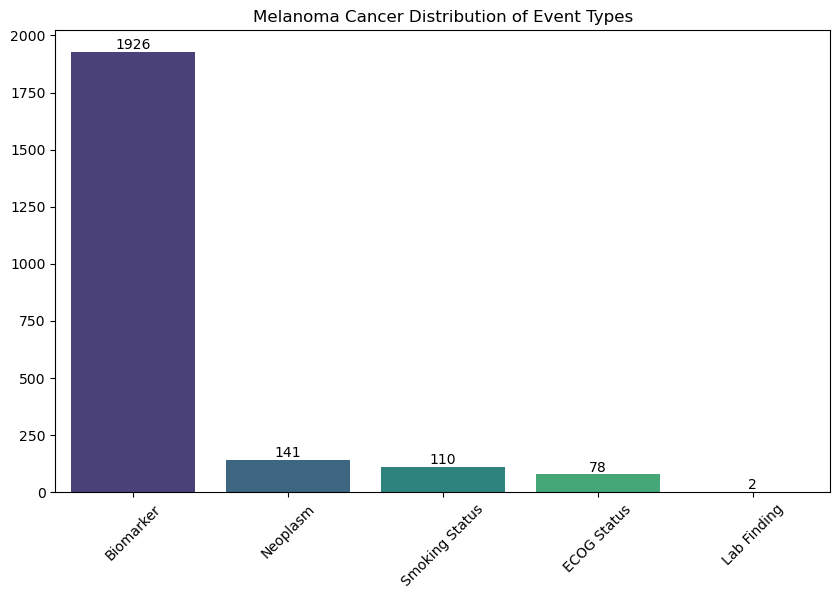

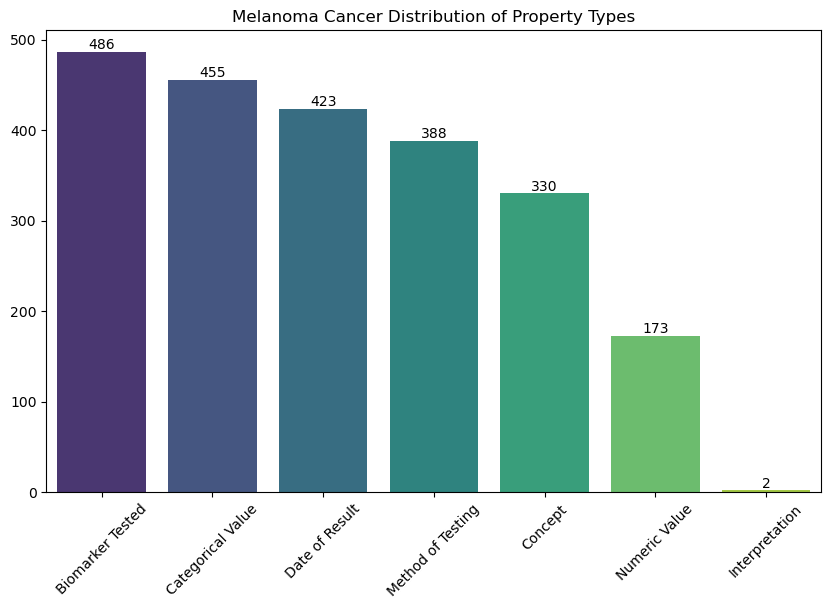

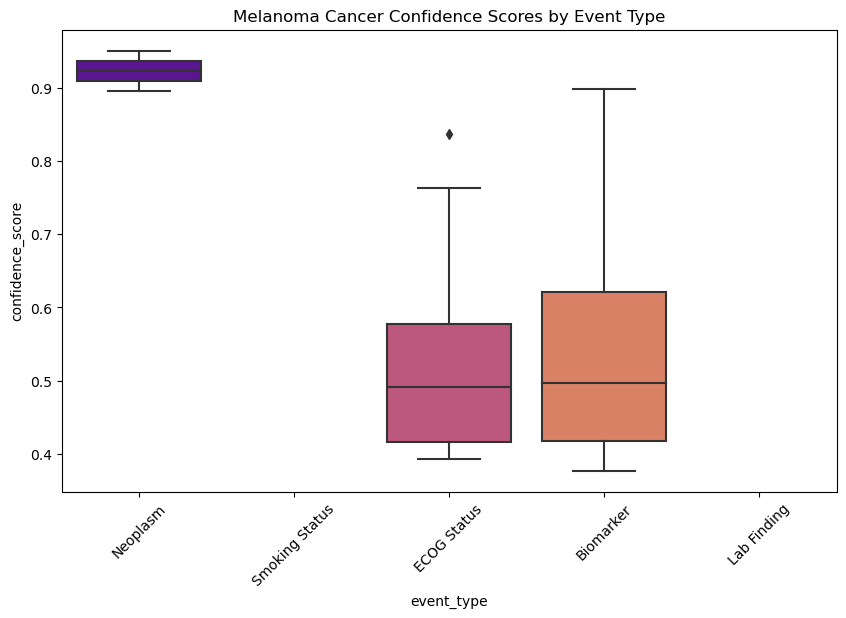

In [20]:
# Distribution of event types
event_type_counts = melanoma_mendel_df['event_type'].value_counts()
create_colorful_bar_plot(melanoma_mendel_df, event_type_counts.index, event_type_counts.values, 'Melanoma Cancer Distribution of Event Types')

# Distribution of property types
property_type_counts = melanoma_mendel_df['property_type'].value_counts()
create_colorful_bar_plot(melanoma_mendel_df, property_type_counts.index, property_type_counts.values, 'Melanoma Cancer Distribution of Property Types')

# Box plot of confidence scores by event type
create_colorful_box_plot(melanoma_mendel_df, 'event_type', 'confidence_score', 'Melanoma Cancer Confidence Scores by Event Type')

In [21]:
print(len(melanoma_mendel_df['all_concept_names'].unique()))
melanoma_concept_counts = melanoma_mendel_df['all_concept_names'].value_counts()
melanoma_concept_counts[:20]

125


Next Generation Sequencing         213
Gene Mutation Negative             186
Melanoma                           140
Sequencing                          88
Immunohistochemistry                75
Gene Mutation                       70
Positive                            65
Never Smoker                        55
PDL1                                41
Variant Of Unknown Significance     40
ECOG 0                              39
Former Smoker                       36
KIT                                 35
TERT                                32
ECOG 1                              32
TP53                                27
HLA                                 26
NF1                                 25
Pathogenic Variant                  25
Negative                            22
Name: all_concept_names, dtype: int64

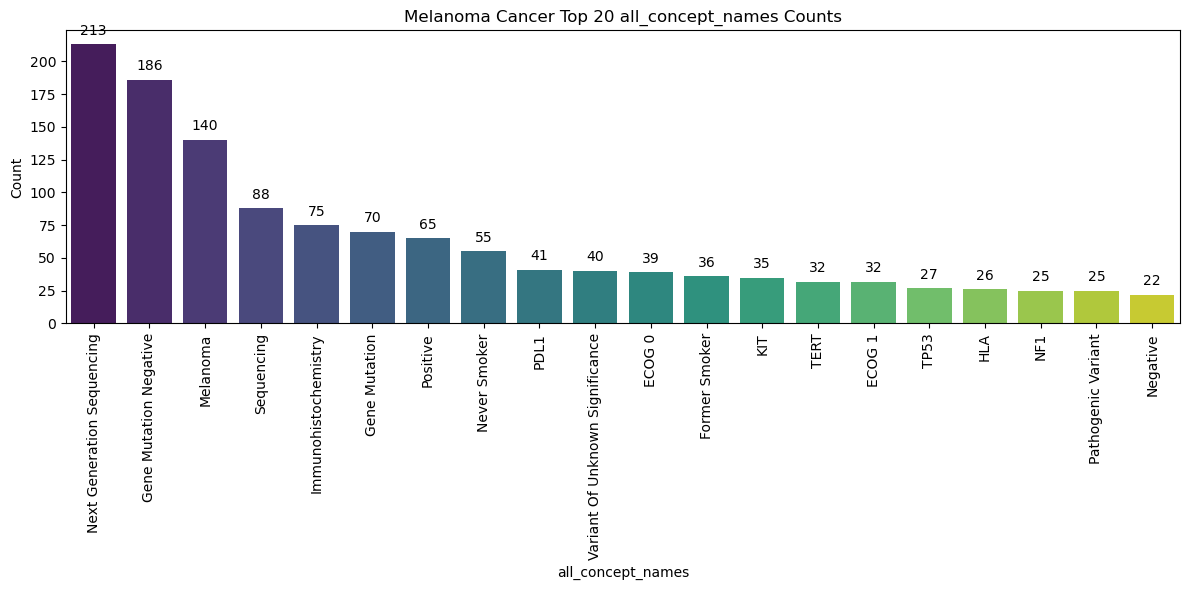

In [24]:
plot_top_concept_counts(melanoma_mendel_df, 'all_concept_names', top_n=20)

### Results Extraction Comparison

In [25]:
# get dataframe with the same patients to compare extracted results 
import re

def merge_common_df(our_df, filtered_df):
    # Extract patient IDs from file names in our_df
    our_df['patient_id'] = our_df['file_name'].apply(lambda x: re.search(r'[A-Za-z0-9]+', x).group())

    # Filter unique patient IDs from our_df
    unique_patient_ids = our_df['patient_id'].unique()
    unique_our_df = our_df[our_df['patient_id'].isin(unique_patient_ids)]

    # Merge with filtered_df based on customer_patient_id
    merged_df = pd.merge(filtered_df, unique_our_df, left_on='customer_patient_id', right_on='patient_id')
    
    # Drop duplicates based on customer_patient_id
    merged_df = merged_df.drop_duplicates(subset='customer_patient_id', keep = 'first')

    return merged_df

In [26]:
merged_melanoma_df = merge_common_df(melanoma_our_df,melanoma_mendel_df )
print(merged_melanoma_df.shape[0])

133


#### Smoking Status

In [27]:
melanoma_smoking_mendel = melanoma_mendel_df[melanoma_mendel_df['event_type'] == 'Smoking Status']
merged_melanoma_df_smoking = merge_common_df(melanoma_our_df, melanoma_smoking_mendel)

In [28]:
print(merged_melanoma_df_smoking.shape)

(105, 19)


In [29]:
def plot_merged_counts(data, column_name, title):
    plt.figure(figsize=(10, 6))
    unique_values = data[column_name].unique()
    num_unique_values = len(unique_values)
    color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors
    
    ax = data[column_name].value_counts().plot(kind='bar', color=[color_map(i) for i in range(num_unique_values)])
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
    
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_56530/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


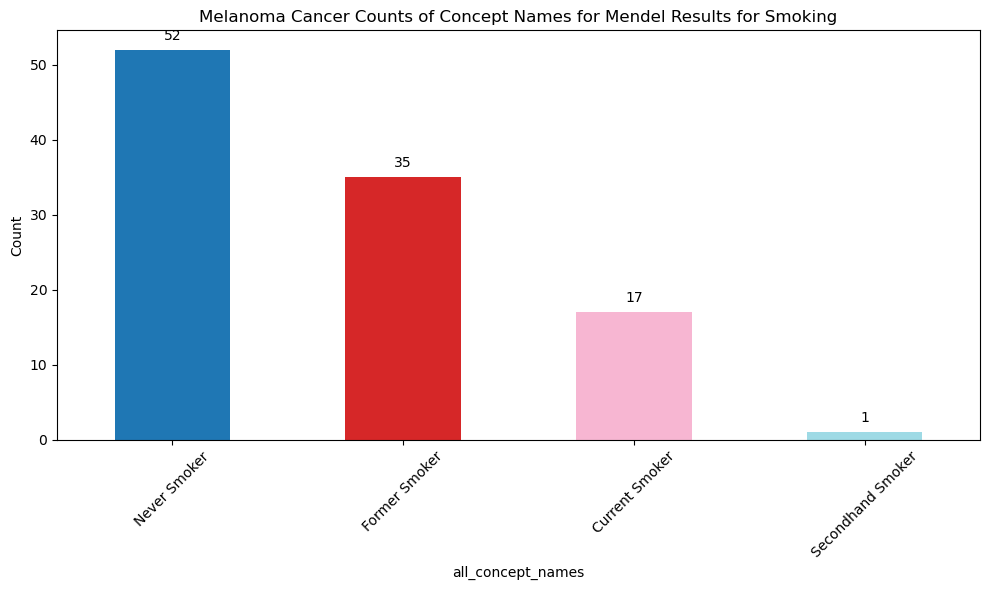

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_56530/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


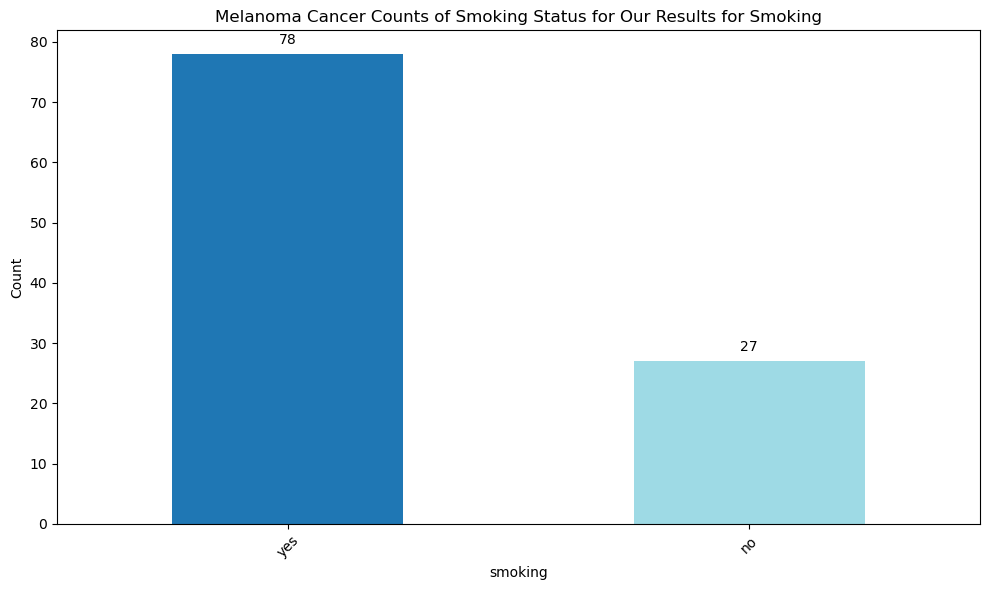

In [30]:
# Plotting counts of 'all_concept_names' for Mendel 
plot_merged_counts(merged_melanoma_df_smoking, 'all_concept_names', 'Melanoma Cancer Counts of Concept Names for Mendel Results for Smoking')

# Plotting counts of 'smoking' for our results 
plot_merged_counts(merged_melanoma_df_smoking, 'smoking', 'Melanoma Cancer Counts of Smoking Status for Our Results for Smoking')

In [31]:
merged_melanoma_df_smoking.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char,file_name,dates,important dates,diseases,smoking,smoking_keyword,ecogs,test_results,patient_id
0,A0552327,Smoking Status,NaN,Concept,Concept,Non smoker,Never Smoker,doc-01h5nw9s3djvr5k3ctjx7wjx7r,3352.0,3362.0,A0552327_MedRec1.txt,"[{'start': 13878, 'end': 13888, 'text': '05/06...","[{'keyword': 'collected: §', 'start': 17254, '...","[{'start': 41, 'end': 66, 'text': 'cancer canc...",yes,smoking,"[{'start': 3070, 'end': 3081, 'text': 'perform...",[],A0552327
1,A0550121,Smoking Status,NaN,Concept,Concept,Non-smoker,Never Smoker,doc-01h5jm4xvrf1hdm534s60d2dbb,1544.0,1554.0,A0550121_MedRec1.txt,"[{'start': 278, 'end': 288, 'text': '11/30/198...",[],"[{'start': 83, 'end': 97, 'text': 'florida can...",no,no smoking,"[{'start': 2607, 'end': 2618, 'text': 'perform...",[],A0550121
2,A0577234,Smoking Status,NaN,Concept,Concept,Never Smoker,Never Smoker,doc-01h5jn0edxh1e8a8bkppc54mj7,4984.0,4997.0,A0577234_MedRec1.txt,"[{'start': 120, 'end': 130, 'text': '12/15/195...",[],"[{'start': 83, 'end': 89, 'text': 'amelia', 'l...",yes,smoking,[],[],A0577234
3,A0582186,Smoking Status,NaN,Concept,Concept,Never smoker,Never Smoker,doc-01h5jmq8nh1r82qm84kybmaewf,1880.0,1892.0,A0582186_MedRec1.txt,"[{'start': 182, 'end': 192, 'text': '10/21/202...",[{'keyword': 'collection date: sep-23-2022 add...,"[{'start': 67, 'end': 73, 'text': 'wilson', 'l...",yes,smoking,"[{'start': 2431, 'end': 2449, 'text': 'perform...",[],A0582186
4,A0626719,Smoking Status,NaN,Concept,Concept,Smoking Status re,Former Smoker,doc-01h5jn9jsrexffh1y3qmn5pwc7,6753.0,6775.0,A0626719_MedRec1.txt,"[{'start': 125, 'end': 135, 'text': '01/05/202...",[{'keyword': 'collected by : w57245_ 202301 — ...,"[{'start': 1551, 'end': 1559, 'text': 'melanom...",yes,smoking,"[{'start': 22936, 'end': 22947, 'text': 'perfo...",[],A0626719


#### Ecogs

In [32]:
melanoma_mendel_ecogs = melanoma_mendel_df[melanoma_mendel_df['event_type'] == 'ECOG Status']

In [33]:
# get the dataframe with same pateints
merged_melanoma_df_ecogs = merge_common_df(melanoma_our_df, melanoma_mendel_ecogs)

In [34]:
print(merged_melanoma_df_ecogs.shape)

(72, 19)


In [35]:
mendel_ecogs_counts = merged_melanoma_df_ecogs['all_concept_names'].count()
print("Number of Mendel ecogs counts: ", mendel_ecogs_counts)

Number of Mendel ecogs counts:  72


In [36]:
non_empty_ecogs_count = merged_melanoma_df_ecogs['ecogs'].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0).sum()
print("Number of our non-empty ecogs:", non_empty_ecogs_count)

Number of our non-empty ecogs: 59


/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_56530/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


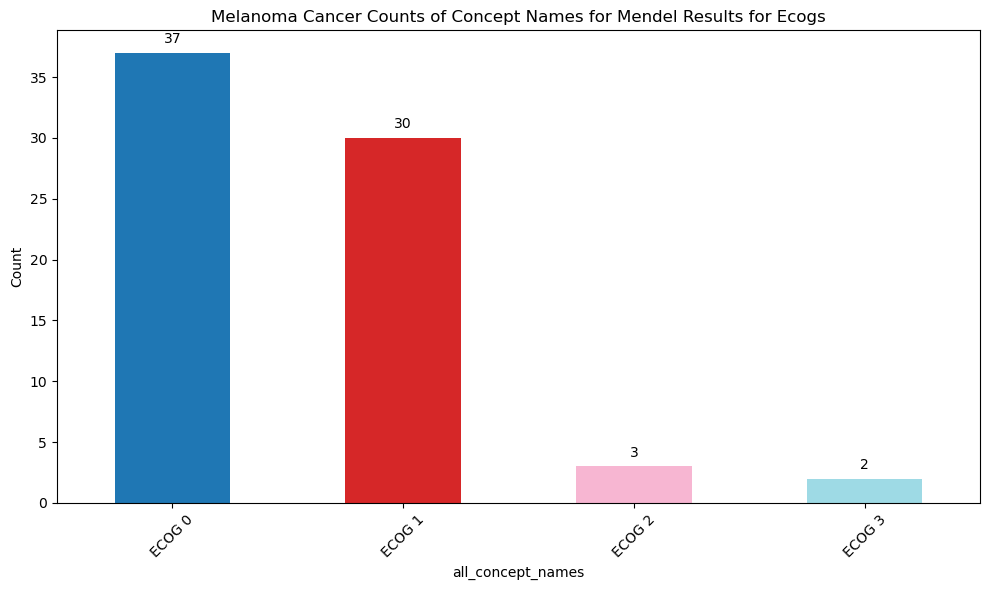

In [37]:
plot_merged_counts(merged_melanoma_df_ecogs, 'all_concept_names', 'Melanoma Cancer Counts of Concept Names for Mendel Results for Ecogs')

#### Test Results

In [38]:
melanoma_test_mendel = melanoma_mendel_df[melanoma_mendel_df['property_type']=='Biomarker Tested']

In [39]:
merged_melanoma_df_test = merge_common_df(melanoma_our_df, melanoma_test_mendel)

In [40]:
merged_melanoma_df_test.shape

(62, 19)

In [41]:
def visualize_our_test_results(our_df, title_for_test_counts):
    # Extract 'test_names' and 'test_values' from 'test_results'
    test_data = []
    for test_result in our_df['test_results']:
        for test in test_result:
            test_data.append({
                'test_name': test['test_name'],
                'test_value': test['test_value']
            })

    # Create a new DataFrame
    test_df = pd.DataFrame(test_data)

    # Plot the counts of 'test_names'
    plot_merged_counts(test_df, 'test_name', title_for_test_counts)

    # Plot the counts of 'test_values' for each 'test_name'
    for test_name in test_df['test_name'].unique():
        filtered_df = test_df[test_df['test_name'] == test_name]
        plot_merged_counts(filtered_df, 'test_value', f'Melanoma Cancer Counts of Test Values for {test_name}')


/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_56530/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


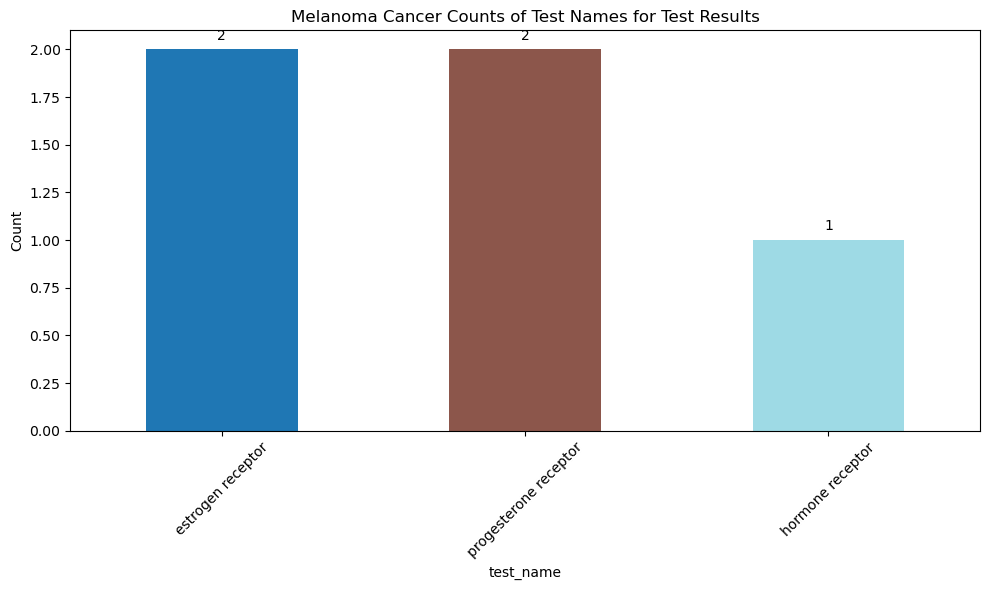

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_56530/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


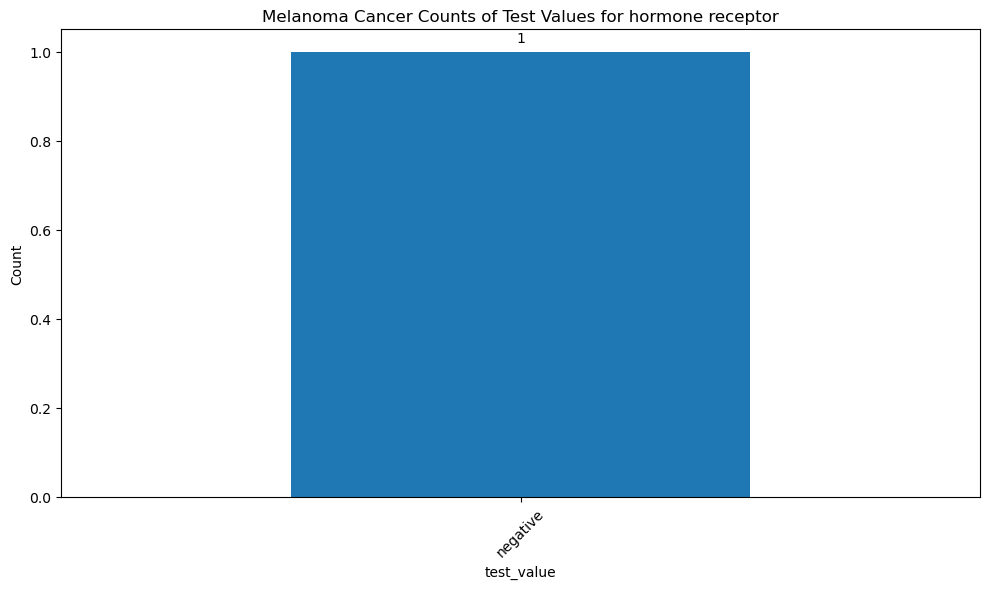

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_56530/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


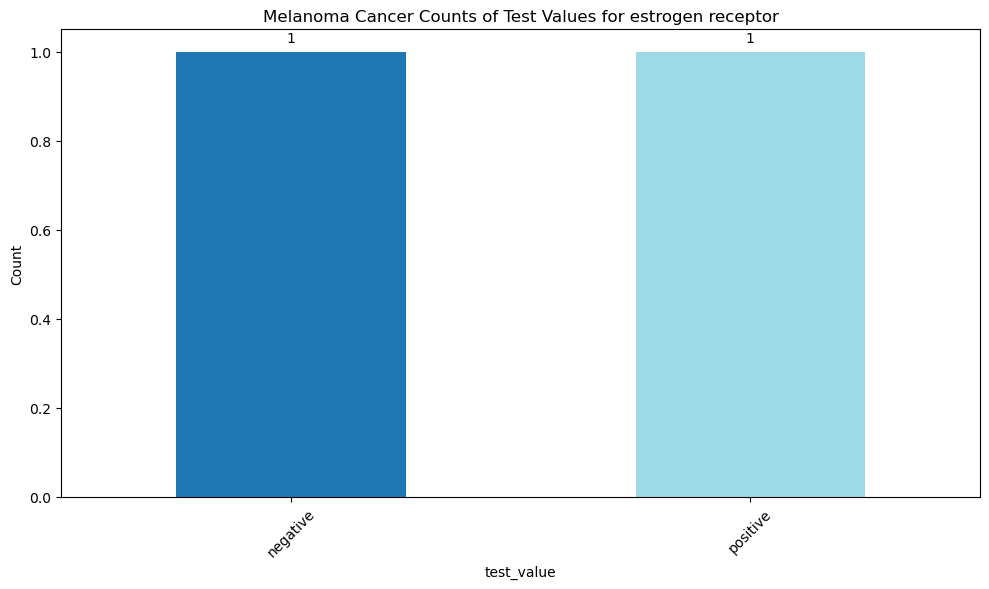

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_56530/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


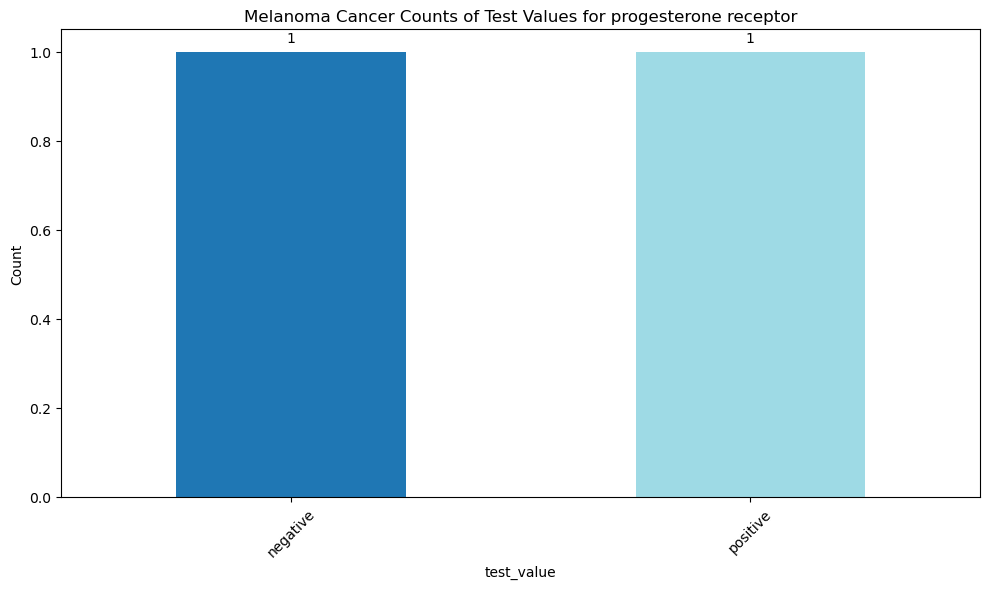

In [42]:
# our test results 
title_our_test_counts = 'Melanoma Cancer Counts of Test Names for Test Results'
visualize_our_test_results(merged_melanoma_df_test, title_our_test_counts)

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_56530/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


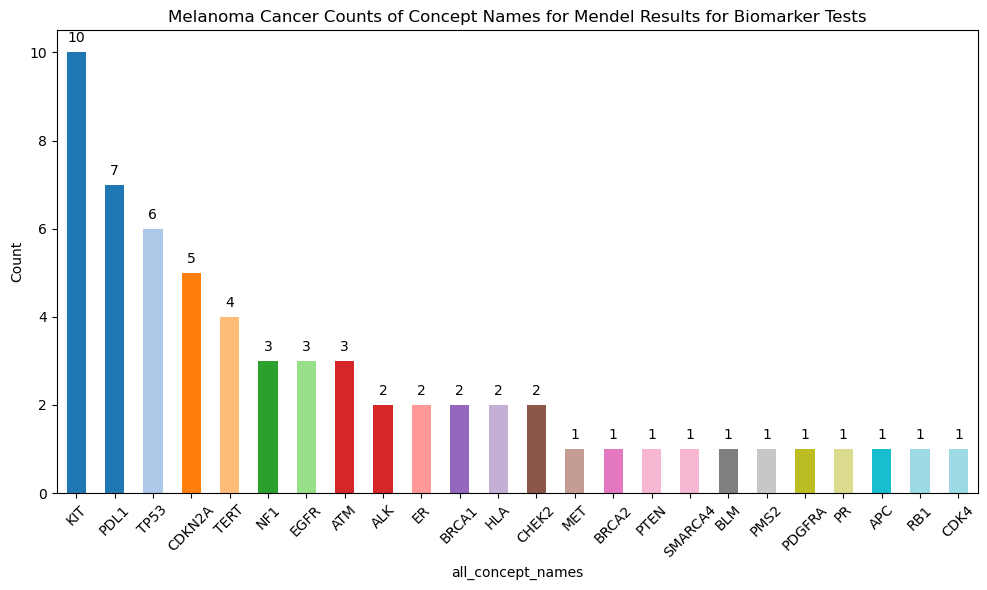

In [44]:
# mendel results 
plot_merged_counts(merged_melanoma_df_test, 'all_concept_names', 'Melanoma Cancer Counts of Concept Names for Mendel Results for Biomarker Tests')

In [52]:
merged_melanoma_df_test[merged_melanoma_df_test['mention'] == 'PR']

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char,file_name,dates,important dates,diseases,smoking,smoking_keyword,ecogs,test_results,patient_id
117,A0576976,Biomarker,NaN,Biomarker Tested,Concept,PR,PR,doc-01h5nw9s9bhd482b81tyzvzaxp,2869.0,2871.0,A0576976_MedRec1.txt,"[{'start': 15, 'end': 25, 'text': '10/14/2022'...","[{'keyword': 'received ned, the tiancr cells a...","[{'start': 726, 'end': 734, 'text': 'melanoma'...",no,,"[{'start': 5768, 'end': 5779, 'text': 'perform...",[],A0576976


#### Important Dates

In [45]:
# Date of Result
melanoma_date_mendel = melanoma_mendel_df[melanoma_mendel_df['property_type']=='Date of Result']

In [46]:
melanoma_date_mendel[:3]

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char
14,A0582186,Biomarker,NaN,Date of Result,String,SEP-28-2022,None,doc-01h5jmq8nv3y2rc55yexs594nm,566.0,578.0
19,A0582186,Biomarker,NaN,Date of Result,String,SEP-28-2022,None,doc-01h5jmq8nv3y2rc55yexs594nm,566.0,578.0
24,A0626719,Biomarker,NaN,Date of Result,String,DEC-27-2022,None,doc-01h5jn9jsqqfkv8zspwtp617j7,13479.0,13491.0


In [47]:
merged_melanoma_df_dates = merge_common_df(melanoma_our_df, melanoma_date_mendel)

In [48]:
merged_melanoma_df_dates.columns

Index(['customer_patient_id', 'event_type', 'confidence_score',
       'property_type', 'property_value_type', 'mention', 'all_concept_names',
       'document_id', 'start_char', 'end_char', 'file_name', 'dates',
       'important dates', 'diseases', 'smoking', 'smoking_keyword', 'ecogs',
       'test_results', 'patient_id'],
      dtype='object')

In [49]:
merged_melanoma_df_dates.shape

(44, 19)

In [50]:
print("Number of results dates extracted by Mendel: ", len(merged_melanoma_df_dates['mention']))

Number of results dates extracted by Mendel:  44


In [51]:
non_empty_important_dates_count = merged_melanoma_df_dates['important dates'].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0).sum()
print("Number of our non-empty important dates:", non_empty_important_dates_count)

Number of our non-empty important dates: 36
